In [196]:
import os, sys
import random
import numpy as np
import errno
import csv
# from PIL import Image
import io
from io import BytesIO
from PIL import Image, ImageFile
import urllib.request
from random import sample

In [197]:
foreground_path= "/Users/kamilademkova/Documents/DSR/Project/images/foregrounds"
background_path= "/Users/kamilademkova/Documents/DSR/Project/images/backgrounds"

#size = 128, 128

def compose_images(foreground, background):
    # Make sure the foreground path is valid and open the image
    #assert os.path.exists(foreground_path), 'image path does not exist: {}'.format(foreground_path)
#     print ("here we go")
#     print (foreground_path)
#     print (os.path.splitext(foreground_path))
#     print ((foreground_path)[1])
#     print ((foreground_path)[1].lower())
   # assert os.path.splitext(foreground_path)[1].lower() == '.png', 'foreground must be a .png file'
    
#    can't use because converts to JPEG and need PNG. even if change outfile as PNG
# for foreground in sys.argv[1:]:
#         outfile = os.path.splitext(foreground)[0] + ".thumbnail"
#         if foreground != outfile:
#             try:
#                 im = Image.open(foreground)
#                 im.thumbnail(size)
#                 im.save(outfile, 'JPEG')
#             except IOError:
#                 print ("cannot create thumbnail for", foreground)
    
    #Make sure foreground has correct amount of bites
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    
#   for i in foreground:
#     with open(foreground, 'rb') as f:
#         b = BytesIO()
#         f.seek(15, 0)
#         b.write(f.read())
    
#     im = Image.open(b)
#     im.load()
    
#     with open("/Users/kamilademkova/Documents/DSR/Project/images/foregrounds/IMG_9715.png", "rb") as f:
#         b = io.BytesIO(f.read())
#         im = Image.open(b)
#         im.save('out.png')

    #foreground = Image.open(foreground_path)
    
    foreground_alpha = np.array(foreground.getchannel(3))
    assert np.any(foreground_alpha == 0), 'foreground needs to have some transparency: {}'.format(foreground_path)
    
    # Make sure the background path is valid and open the image
    assert os.path.exists(background_path), 'image path does not exist: {}'.format(background_path)
    
    print (background_path)
    print (os.path.splitext(background_path)[1])
    
    assert os.path.splitext(background_path)[1].lower() in ['.png', '.jpg', 'jpeg'], \
        'foreground must be a .png or .jpg file: {}'.format(foreground_path)
    #background = Image.open(background_path)
    #background = background.convert('RGBA')

    # Rotate the foreground
    angle_degrees = random.randint(0, 359)
    foreground = foreground.rotate(angle_degrees, resample=Image.BICUBIC, expand=True)
    
    # Scale the foreground
    scale = random.random() * .3 + .7 # Pick something between 0.7 and 1
    new_size = (int(foreground.size[0] * scale), int(foreground.size[1] * scale))
    foreground = foreground.resize(new_size, resample=Image.BICUBIC)
    
    # Add any other transformations here...
    
    # Choose a random x,y position for the foreground
    max_xy_position = (background.size[0] - foreground.size[0], background.size[1] - foreground.size[1])
    assert max_xy_position[0] >= 0 and max_xy_position[1] >= 0, \
        'foreground {} is to big for the background {}'.format(foreground_path, background_path)
    paste_position = (random.randint(0, max_xy_position[0]), random.randint(max_xy_position[1]//2, max_xy_position[1]))
    


    # Create a new foreground image as large as the background and paste it on top
    new_foreground = Image.new('RGBA', background.size, color = (0, 0, 0, 0))
    new_foreground.paste(foreground, paste_position)
        
    # Extract the alpha channel from the foreground and paste it into a new image the size of the background
    alpha_mask = foreground.getchannel(3)
    new_alpha_mask = Image.new('L', background.size, color=0)
    new_alpha_mask.paste(alpha_mask, paste_position)
    composite = Image.composite(new_foreground, background, new_alpha_mask)
    
    # Grab the alpha pixels above a specified threshold
    alpha_threshold = 200
    mask_arr = np.array(np.greater(np.array(new_alpha_mask), alpha_threshold), dtype=np.uint8)
    hard_mask = Image.fromarray(np.uint8(mask_arr) * 255, 'L')
    
    # Get the smallest & largest non-zero values in each dimension and calculate the bounding box
    nz = np.nonzero(hard_mask)
    bbox = [np.min(nz[0]), np.min(nz[1]), np.max(nz[0]), np.max(nz[1])]
    y1 = bbox[0]  #min
    x1 = bbox[1]  #min
    y2 = bbox[2]  #max
    x2 = bbox[3]  #max

    
#     center-x = x / W width(in pixels) of the whole image
    cx = ((x2+x1)/2)/composite.size[0]
#     center-y = y / H height(in pixels) of the whole image
    cy = ((y2+y1)/2)/composite.size[1]
#     width = w / W width(in pixels) of the whole image
    width = (x2 - x1)/composite.size[0]
#     height = h / H height(in pixels) of the whole image
    height = (y2 - y1)/composite.size[1]
# x – x-coordinate(in pixels) of the center of the bounding box
# y – y-coordinate(in pixels) of the center of the bounding box
# w – width(in pixels) of the bounding box
# h – height(in pixels) of the bounding box
# W – width(in pixels) of the whole image
# H – height(in pixels) of the whole image

    return composite, hard_mask, bbox, cx, cy, width, height

In [200]:
# Get lists of foreground and background image paths
dataset_dir = '/Users/kamilademkova/Documents/DSR/Project/images'
backgrounds_dir = os.path.join(dataset_dir, 'backgrounds')
foregrounds_dir = os.path.join(dataset_dir, 'foregrounds')
backgrounds = [os.path.join(backgrounds_dir, file_name) for file_name in os.listdir(backgrounds_dir) if not file_name.startswith('.')]
foregrounds = [os.path.join(foregrounds_dir, file_name) for file_name in os.listdir(foregrounds_dir) if not file_name.startswith('.')]

#[f for f in os.listdir(path) if not f.startswith('.')]

# Create an output directory
output_dir = os.path.join(dataset_dir, 'generated')
try:
    os.mkdir(output_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

# Create a list to keep track of images and mask annotations
csv_lines = []

# Generate # new images
for i in range(4500):
    background_path = random.choice(backgrounds)
    
#     sample_size= np.random.choice(range(6))    
#     foregrounds_selections = random.sample(os.listdir(foreground_path), sample_size)
#     foreground = Image.open(foreground_path)
    bbtx_path = os.path.join(output_dir, 'image_{0:04d}.txt'.format(i))
    
    f = open(bbtx_path, "w+")
    
    background_path = random.choice(backgrounds)
    background = Image.open(background_path)
    background = background.convert('RGBA')
    
    foreground_path = random.choice(foregrounds)    
    foreground = Image.open(foreground_path)
 
    composite, mask, bbox, cx, cy, width, height = compose_images(foreground, background)
    
    composite_path = os.path.join(output_dir, 'image_{0:04d}.png'.format(i))
    composite.save(composite_path)
    
    mask_path = os.path.join(output_dir, 'mask_{0:04d}.png'.format(i))
#    mask.save(mask_path)
    

    f.write("0" +" "+ str(cx)+" "+ str(cy)+" "+ str(width) +" " +str(height) +"\n")

    
#    csv_lines.append([composite_path, bbox, mask_path])

    random_number=random.randint(0,5)
    
    for i in range(random_number):
        background=0
        background = Image.open(composite_path)
        foreground_path = random.choice(foregrounds)    
        foreground = Image.open(foreground_path)
        composite, mask, bbox, cx, cy, width, height = compose_images(foreground, background)
        f.write("0" +" "+ str(cx)+" "+ str(cy)+" "+ str(width) +" " +str(height) +"\n")
        composite.save(composite_path)
        
        
    f.close()
        
        
    
# Output the annotations csv
annotations_csv_path = os.path.join(output_dir, 'annotations.csv')
with open(annotations_csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for csv_line in csv_lines:
        writer.writerow(csv_line)

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4381_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4381_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4381_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4381_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4824_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4824_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4824_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4824_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4824_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4659_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4659_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5095_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5095_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5095_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5095_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5500_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4126_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4126_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4126_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5641_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5641_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5641_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5641_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4349_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4349_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4349_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4349_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4881_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4881_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4881_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4881_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5689_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5689_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5689_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4577_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4577_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4360_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4360_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4315_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4315_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4315_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4315_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4536_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4458_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4458_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4458_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4458_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4458_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5177_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4545_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4545_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4756_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4756_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4756_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4756_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5086_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5086_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4492_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4492_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4492_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4540_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4540_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4709_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4709_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4709_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4709_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4865_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4865_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4865_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4883_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4883_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4883_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4883_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4883_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4681_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4681_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4681_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5232_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5232_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5232_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5232_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5232_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4665_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4665_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4665_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4665_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4380_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4657_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4657_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4657_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4657_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5167_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5167_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5344_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4672_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4672_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4722_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4722_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4722_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4722_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4722_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5218_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4591_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4591_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4591_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4591_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4591_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5630_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5630_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5630_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5630_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5630_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5630_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4746_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4746_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4746_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4746_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4746_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5648_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5648_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5648_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5648_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5648_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5007_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5007_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5007_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4625_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4328_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4328_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4632_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4442_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4442_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4442_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4726_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4726_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4726_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4788_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5413_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5413_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5413_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5114_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5114_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5114_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4484_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4723_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4723_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4723_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4723_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4328_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4328_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4328_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5671_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5671_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4289_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4399_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4399_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4399_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5619_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5073_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5073_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4397_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4397_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4397_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4381_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5641_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5641_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5641_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4426_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4426_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5630_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5630_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5630_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5630_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5630_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5630_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5659_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5659_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5080_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5080_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5080_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5612_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5612_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5612_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4146_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4146_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4146_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4146_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4505_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4505_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4505_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5347_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4663_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4498_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4498_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4498_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4498_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4498_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4498_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5118_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5118_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5118_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5118_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4818_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4818_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4818_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4818_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4818_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4818_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4666_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5588_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5588_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5588_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5095_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4721_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4721_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4721_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4721_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4721_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4151_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4151_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5275_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4263_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4263_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4263_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4263_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4263_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4263_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4568_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4935_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5632_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5632_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5664_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5664_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5664_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4224_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4966_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4966_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4966_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5020_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5020_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5020_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5020_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4344_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4344_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4344_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4344_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5105_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5105_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5105_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5105_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5105_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5105_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5513_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4986_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4986_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4986_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4986_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5114_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4831_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4631_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4631_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4933_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4933_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4933_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4933_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4933_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4933_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4740_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4438_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4438_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5239_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5239_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5239_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5239_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5219_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5610_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4949_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4949_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4949_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4299_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4299_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4460_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4460_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4460_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4460_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4460_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5110_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5110_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5110_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5110_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4759_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4795_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4795_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4795_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4795_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4795_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4684_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4684_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4684_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4684_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4684_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5576_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4910_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4910_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4910_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4910_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4910_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5445_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5445_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5445_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5445_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5445_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4303_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5416_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5416_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5416_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5416_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5416_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5416_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5319_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5319_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5319_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5319_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4456_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5536_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5536_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4131_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4131_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4131_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4131_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4131_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4793_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4793_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4793_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4882_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4882_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4245_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4245_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4651_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4651_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4651_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5625_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5625_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5625_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5625_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5100_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4289_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4289_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4289_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4289_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4289_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4224_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4224_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4224_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5239_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5239_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5311_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5311_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5311_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4325_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4325_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4325_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4132_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4132_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4944_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4944_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4944_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4944_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4444_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4444_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4603_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4603_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4603_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5208_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5208_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5208_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5208_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4218_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4218_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4218_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4218_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4484_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4484_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4484_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4140_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4140_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4140_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4140_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4848_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4848_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4848_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4848_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4848_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5149_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5149_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5524_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5524_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5449_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5449_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5449_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5449_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5449_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5535_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5684_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5684_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5684_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5183_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5183_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4654_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4654_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4654_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4654_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4654_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5529_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5529_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5529_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5529_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4776_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4776_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4776_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4776_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5365_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5365_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5365_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5365_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5365_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4132_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4132_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5230_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4163_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4497_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4497_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4497_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4497_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4497_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4497_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5492_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5492_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5492_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5159_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5159_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5359_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5359_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5359_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5359_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5365_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5365_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5365_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4743_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4743_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5216_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5216_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5216_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5216_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5216_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5263_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5263_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4489_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4489_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4489_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4720_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4254_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4254_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4254_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4254_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4254_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4631_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4631_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4631_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4631_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4631_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4184_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4842_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5673_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5673_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5673_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5673_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4384_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4384_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4178_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4178_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5550_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5550_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5206_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5021_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5021_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5021_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5021_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4547_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4599_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4599_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4599_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4599_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4599_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4438_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4438_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5504_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5504_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5504_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5504_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4332_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4332_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4332_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4332_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4332_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5319_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4789_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4789_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4789_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5676_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5676_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5676_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5149_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5149_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4291_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5265_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4243_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5167_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5622_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5622_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5622_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5622_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5622_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5638_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5638_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5638_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5638_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4267_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4267_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4267_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4567_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4567_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4567_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4567_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4567_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4567_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4516_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4516_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5044_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5044_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5170_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5170_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5081_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5081_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5081_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5081_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4290_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4290_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4290_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5579_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5355_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5355_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5572_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4227_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4227_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4227_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4227_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4227_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4227_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4843_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4772_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4772_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4772_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4772_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4772_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5030_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4922_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4922_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4922_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4922_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4922_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4447_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4447_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4447_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4447_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4567_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4567_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5076_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4531_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4191_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4191_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4191_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4410_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5014_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5014_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5014_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5014_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5014_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5014_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4814_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4814_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4640_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4984_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4783_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4783_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4783_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4233_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4233_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4511_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5035_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5035_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4237_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4237_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4237_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5372_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5668_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5668_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4823_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4823_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4823_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4910_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5347_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4513_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4513_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4513_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5213_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5213_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5380_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5380_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5380_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5380_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5380_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5380_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4526_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4526_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4526_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4958_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4958_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4958_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4958_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4958_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5092_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5092_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5092_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5092_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4381_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4381_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4514_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4514_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5387_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5387_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5154_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5154_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5540_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5540_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5540_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5540_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5540_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4238_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5133_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5404_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4305_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4305_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4305_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4957_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4957_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4922_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4922_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4922_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5130_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5638_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5197_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5197_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5197_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5197_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5197_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5197_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5214_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5214_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5214_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4254_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4254_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5671_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5671_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5671_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5671_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5671_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5671_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5567_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5567_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5567_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5343_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5343_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5343_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4219_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4219_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5347_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5347_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5347_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5347_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5347_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5075_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5643_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4126_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4126_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4126_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4126_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5669_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5669_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5669_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5164_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5164_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5164_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4761_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4761_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4761_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4365_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4365_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5336_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5336_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5336_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5543_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5414_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5414_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5389_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5541_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4235_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4235_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4235_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4235_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4153_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4888_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4888_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4888_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4888_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4888_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4888_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5403_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4891_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4891_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4891_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4891_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4891_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4627_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4627_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4627_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4627_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4627_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4627_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4573_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4573_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4597_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4597_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4597_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4597_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4597_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5032_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4876_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4876_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4876_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4175_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4175_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4206_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5353_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5036_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5036_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5036_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5036_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5036_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5235_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4894_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5693_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5693_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5693_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5693_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5258_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5258_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5386_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5068_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5068_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5600_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5600_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4461_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4461_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4396_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4396_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5449_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5449_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5449_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5449_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5235_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5235_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5235_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5068_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5068_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5268_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5268_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5268_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5268_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5268_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5268_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5544_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5544_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4441_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4669_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5550_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5550_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5550_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5550_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5550_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4639_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4829_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5631_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5631_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5631_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5214_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5214_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5214_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5214_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4742_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4742_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4449_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4353_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4881_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4881_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4881_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5296_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5296_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5296_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5602_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5602_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4432_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4432_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4188_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5169_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4394_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4394_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4394_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4394_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4394_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4884_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4884_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4159_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4159_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4922_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4526_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4526_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4526_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4526_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5594_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5594_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5594_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5626_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5626_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5626_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5626_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4145_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4145_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4839_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4839_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5673_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4551_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4551_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4551_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4551_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4632_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4172_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4172_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4172_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4829_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4829_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4829_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4499_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4622_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4622_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4622_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4622_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5433_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5433_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5295_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5295_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5295_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5295_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5295_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4127_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4127_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4127_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4127_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4937_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4937_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4937_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4394_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4394_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4394_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4394_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4394_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5445_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4560_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4984_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4984_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4984_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4984_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4984_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5119_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5119_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5609_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5609_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4664_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4664_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4782_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4782_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4782_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4782_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4782_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4928_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4153_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4722_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4722_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4722_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4470_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4470_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4470_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4470_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4470_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4470_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5351_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5351_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4679_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5082_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5082_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5079_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5079_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5079_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5079_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5079_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4257_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4373_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4373_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4727_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4727_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4727_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5640_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5640_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5640_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5640_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4685_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5654_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4336_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4336_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4336_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4336_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4336_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4336_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5335_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5335_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5335_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4238_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4238_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4198_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4198_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5147_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5147_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5147_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5262_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5262_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5654_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5654_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5654_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5654_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5176_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5176_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5176_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4594_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4886_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4886_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4266_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4266_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4266_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4429_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4429_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5129_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5129_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5129_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5129_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5679_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5679_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5605_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5605_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5605_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4771_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4771_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4897_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4962_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4962_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4962_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4962_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4962_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5250_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5250_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5250_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5690_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5690_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5502_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5502_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4305_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4305_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4305_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4305_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4305_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4305_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4450_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4530_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5080_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4452_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4951_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5234_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5234_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5234_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5234_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5234_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5080_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5354_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5354_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5354_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5012_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5012_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5012_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5012_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5012_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5012_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4772_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4772_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4835_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4835_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5340_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5340_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5340_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4907_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4907_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4907_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4907_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4907_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4907_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4995_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4995_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4995_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4995_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5641_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5641_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5074_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5074_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5074_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5074_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4825_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4453_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4453_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4453_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4453_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4208_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5647_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5647_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5647_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4149_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4149_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4149_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4135_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4135_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4135_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4403_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4403_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4504_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5220_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5220_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5220_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5220_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5220_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4186_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4186_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4186_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4186_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4186_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5247_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4848_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5607_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5607_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5607_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5607_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5607_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5607_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4657_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4657_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4657_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4657_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5374_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5188_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5188_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5188_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5188_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5188_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4797_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4797_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5447_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5219_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5219_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5219_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4572_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5357_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5357_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5357_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5157_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4135_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4135_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4135_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4135_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5328_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5328_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4750_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4750_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4750_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5274_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5274_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5274_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5274_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5032_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5032_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5032_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5032_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5098_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5445_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4851_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4851_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4851_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4522_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4522_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4522_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4522_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4805_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4805_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4805_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4837_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4837_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4837_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4837_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5215_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5215_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5215_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5215_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4798_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4798_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4798_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4373_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5186_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5186_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5186_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4501_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4180_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4180_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4180_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4180_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4837_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4444_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4444_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4417_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4567_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4567_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5058_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5058_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5058_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5058_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4703_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4703_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4703_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4703_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4703_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4703_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4183_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4636_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4636_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4636_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4636_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5380_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5380_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5380_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5380_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4875_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4875_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5378_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4413_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5256_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5256_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5256_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5256_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4797_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5672_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5510_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5510_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5510_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5510_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4595_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4595_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4595_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4595_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4211_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4211_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5315_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5315_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5315_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5315_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5117_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5117_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4325_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4325_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4621_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4621_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4198_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4198_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4198_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4829_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4803_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4803_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4428_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4428_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4428_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4158_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4158_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4158_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4158_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4478_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4478_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5365_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5365_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5365_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5399_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5399_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5399_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4249_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4249_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4249_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4249_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4249_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5313_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4843_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4612_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4612_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4612_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4612_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4612_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4213_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4213_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4213_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4213_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4387_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4387_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4387_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4387_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4387_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5026_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5026_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5247_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4129_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4129_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4129_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4517_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4517_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4816_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4160_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4277_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4277_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4277_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4277_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4277_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4277_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4387_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5201_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5201_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5201_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5201_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5201_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5108_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5108_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5108_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4585_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4585_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4585_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4424_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4424_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4424_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4424_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4424_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4957_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5186_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5186_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5186_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5685_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5685_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5038_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5038_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4359_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4359_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4359_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4395_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4395_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4395_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4305_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4468_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4847_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4508_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4508_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5687_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4384_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4384_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4384_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4435_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4435_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4425_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4425_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4874_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4874_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4874_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5647_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5647_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5647_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5647_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5596_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5077_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5077_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4317_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4317_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4166_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4166_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4744_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4380_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4380_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4380_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4284_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4284_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4284_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4284_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4780_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4780_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4780_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4780_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4780_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4780_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4563_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4675_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4675_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4675_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5298_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5298_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4128_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4128_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4128_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4128_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4128_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4314_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4859_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4859_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5595_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5595_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5595_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5595_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5595_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5595_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5440_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5440_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5236_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4305_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4465_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4465_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4465_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5684_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5684_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5684_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5684_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5684_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5684_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4334_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4621_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5085_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5085_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5085_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5085_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4866_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4866_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4866_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4866_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4866_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5395_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4864_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4218_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4218_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4218_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4218_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4218_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4218_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4876_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4595_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4595_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4595_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5381_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5381_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5381_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5381_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5381_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5245_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5245_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5245_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5245_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5245_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4643_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5618_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4490_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4424_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4424_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4424_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4424_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4424_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4298_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4298_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4298_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4298_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4289_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4289_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5569_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5569_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5569_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5569_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5569_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5569_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5006_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5547_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5547_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5220_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5220_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5220_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4850_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4850_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4850_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4919_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4919_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4919_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4919_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4629_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4629_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4629_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4629_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4650_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4650_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4650_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4271_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4271_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4271_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4271_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4216_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5285_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5285_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5285_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5285_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5285_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4605_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4528_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4528_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4243_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4243_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4243_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4243_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4243_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4615_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4615_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4855_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5412_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4503_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4811_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4811_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4811_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4811_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5130_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5130_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5130_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5130_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4267_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5095_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5013_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4150_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5115_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5115_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5115_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5115_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5115_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4606_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4606_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4606_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5620_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5620_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5620_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5620_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5287_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5287_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5287_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5287_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4515_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4515_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4515_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4515_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4515_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4515_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4141_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4141_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4141_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4950_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4950_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4748_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4748_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5017_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5017_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5017_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5017_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5017_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5625_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5625_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5625_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5625_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5196_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5196_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5196_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5196_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5196_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4604_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4604_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4604_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5631_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5631_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5631_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4614_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5320_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5320_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5320_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4239_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4239_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4239_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5383_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5383_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4503_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4503_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4919_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4609_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5018_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5018_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5018_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5018_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5018_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5018_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5444_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5444_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5444_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4430_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4430_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4430_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4430_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5175_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5175_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5175_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5406_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5406_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5406_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5406_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5272_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5272_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5272_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4379_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4149_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4149_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4149_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4149_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4149_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4149_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5412_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4516_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4516_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4516_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4516_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4749_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4922_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4922_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4890_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4890_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4890_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4890_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4676_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4323_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4323_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4323_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4323_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4323_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4881_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4554_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4554_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4286_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4286_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4286_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4286_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4286_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4705_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4933_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5106_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5106_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5106_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5106_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4284_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4284_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4284_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4284_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4284_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4227_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4227_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4227_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4227_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4227_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4700_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4700_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4740_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4740_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4740_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5219_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4735_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4744_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4744_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4744_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4744_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4744_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4643_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4325_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4325_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4325_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4325_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5569_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5569_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5569_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5569_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5004_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5004_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5004_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5004_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5004_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5004_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5328_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5012_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5012_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5012_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5012_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5012_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5012_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4271_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4271_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5676_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5676_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5676_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4677_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5610_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5352_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5352_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5352_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5352_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5352_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5352_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5300_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5377_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5377_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5377_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5377_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5377_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5422_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5422_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4622_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4622_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5097_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5097_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5097_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5097_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5097_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5670_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5670_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4420_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4420_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4750_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4750_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4750_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5088_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5088_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5088_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5088_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5088_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5597_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5597_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5597_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5168_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5168_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5592_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4480_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4480_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4480_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4480_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4480_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5410_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4209_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4209_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4209_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4893_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4893_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4893_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4893_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4893_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5691_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5691_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5017_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5017_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4720_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4720_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4720_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4720_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4720_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4709_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4331_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4331_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4331_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5560_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5560_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5635_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5635_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5635_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5635_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5635_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4864_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4864_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5368_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5368_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4460_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4460_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4249_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4249_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4249_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4249_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4249_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4249_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5214_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4416_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4416_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4377_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4377_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4269_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4269_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4567_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4567_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5097_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5097_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4830_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4830_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4830_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4580_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4580_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4919_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4919_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4919_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4919_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5133_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5133_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5133_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5133_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5133_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4143_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4172_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4172_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4172_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4172_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4172_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4964_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4964_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4738_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4738_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4738_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5373_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4141_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4141_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4141_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5268_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5268_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5268_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4143_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4143_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4143_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4143_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4292_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4138_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4302_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4302_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5426_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5426_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5426_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5426_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5426_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4666_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5665_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5665_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5665_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4868_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4868_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4868_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4868_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4868_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4484_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4484_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4484_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4202_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4202_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4986_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4986_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4986_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4613_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4613_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4143_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4143_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4143_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4143_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5539_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5539_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5539_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5539_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4175_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4175_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4175_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4175_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4175_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4175_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5372_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4419_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4419_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4419_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5082_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5082_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4656_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4656_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5195_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5195_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5195_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4870_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4215_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4215_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4215_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4998_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4998_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4481_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4481_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4481_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4481_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4644_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4644_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4644_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5081_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5081_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5081_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4873_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4296_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5198_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5198_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5198_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5198_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5198_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4126_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4126_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4126_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4583_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4843_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5022_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5046_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5648_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5648_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5648_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5648_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4619_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5619_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4891_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4891_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4891_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4891_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4891_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4891_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4487_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4487_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4487_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4777_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4970_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5166_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5166_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5166_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5166_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5166_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5166_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5229_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5229_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5229_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5229_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4776_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4776_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4886_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4336_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4336_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4642_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4642_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4642_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4642_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4642_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4794_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5512_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5512_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5550_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5550_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4412_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5600_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5600_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5344_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4534_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4534_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4534_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4534_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4534_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4534_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4327_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5446_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5446_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4707_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4707_cam

KeyboardInterrupt: 

In [181]:
# check if have extra bites
# with open('/Users/kamilademkova/Documents/DSR/Project/images/foregrounds/glassimg.png', 'rb') as fp:
#     data = fp.read()
#     out = []
#     for char in data[:23]:
#         out.append(str(char))
#     print(' '.join(out))
# output 137 80 78 71 13 10 26 10 0 0 0 13 73 72 68 82 0 0 10 112 0 0 10
# should be 137 80 78 71 13 10 26 10

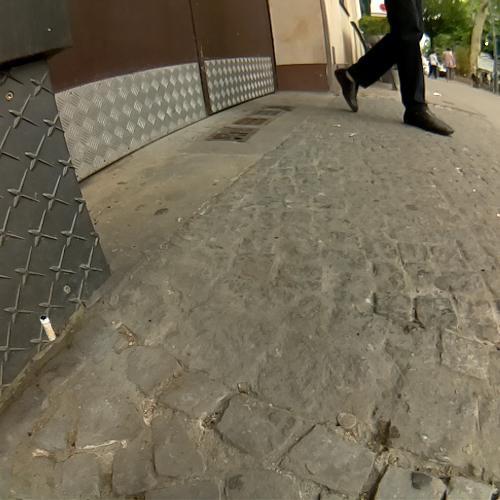

In [182]:
sample_image_path = csv_lines[0][0]
sample_image = Image.open(sample_image_path)
sample_image

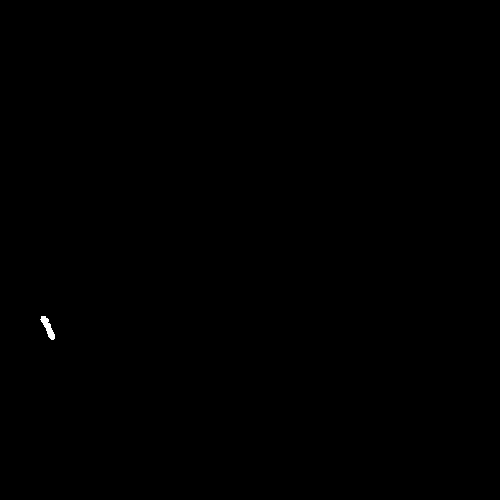

In [183]:
sample_mask_path = csv_lines[0][2]
sample_mask = Image.open(sample_mask_path)
sample_mask